In [23]:
import torch
import torch.nn as nn
from torch import tensor as Tensor
import matplotlib as plt
from math import exp

N = 100
h = 1.0 / N
eps = -1.0
deg = 2
sigma = 10.0 * deg * deg
X = torch.linspace(0, 1, N+1)
print(X, X.dtype)

def testfunc(x, i, n):
    ''' ith test function of cell n'''
    x_mid = (X[n] + X[n+1]) / 2.0
    return 2**i * (x - x_mid)**i / (X[n+1] - X[n])** i

def grad_testfunc(x, i, n):
    ''' gradience of ith test function of cell n'''
    if i == 0:
        return 0
    else:
        x_mid = (X[n] + X[n+1]) / 2.0
        return 2**i * i * (x - x_mid)**(i-1) / (X[n+1] - X[n])** i
    
###################################################### Particle test function ##########################################################
def particletest(r):
    '''particle test function in the nth cell, the refenece coordinate is x'''
    if r < 1+1e-9 and r>-1e-9:
        return (1-r)**5 * (8*r**2+5*r+1)
    else:
        print("r>1, somthing went wrong!")


def grad_particletest(r):
    if r < 1+1e-9 and r>-1e-9:
        return -14*r*(4*r+1)*(1-r)**4
    else:
        print("r>1, somthing went wrong!")

def source(x):
    return (4*x**3 - 4*x**2-6*x + 2) * exp(-x**2)

# class u(nn.Module):
#     def __init__(self, *args, **kwargs) -> None:
#         super().__init__(*args, **kwargs)
#         self.layer1 = nn.Linear(1, 10)
#         self.layer2 = nn.Linear(10, 10)
#         self.layer3 = nn.Linear(10, 1)
#     def forward(self, x):
#         o1 = torch.relu(self.layer1(x))
#         o2 = torch.relu(self.layer2(o1))
#         op = torch.relu(self.layer3(o2))
#         return op

class u(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 1)
    def forward(self, x):
        x = x[0:1]
        input = torch.cat([x, x**2])
        o1 = self.layer1(input)
        op = self.layer2(o1)
        return op

bflist = []
for _ in range(N):
    bf = u()
    bflist.append(bf)

def ref2phi(s, n):
    ''' s is the position of one dim'''
    return (s + 1) / 2.0 * (X[n+1] - X[n]) + X[n]

def computeAB(bflist, notf):
    s = [-0.86113631, -0.33998104, 0.33998104, 0.86113631]
    w = Tensor([0.17392742, 0.32607257, 0.32607257, 0.17392742])
    ng = w.shape[0]
    A = Tensor([0.0])
    B = Tensor([0.0])

    for n in range(N):
        for k in range(ng):
            realcor = ref2phi(s[k], n)
            bf = bflist[n]
            p = Tensor([realcor], requires_grad=True)
            up = bf(p)
            gup = torch.autograd.grad(up, p, create_graph=True, retain_graph=True)[0]

            v = testfunc(p, notf, n)
            gv = grad_testfunc(p, notf, n)

            f = source(p)
            A += w[k] * (X[n+1] - X[n]) * gup * gv
            B += w[k] * (X[n+1] - X[n]) * f * v
        return A, B

# print(computeAB(bflist, 3, 1))

def computeC(bflist, notf):
    ''' input the list of testfunction, tell nth cell asn compute about notf_th of test function'''
    C = Tensor([0.0])

    bf0 = bflist[0]
    p0 = Tensor([0.0], requires_grad=True)
    u0 = bf0(p0)
    gu0 = torch.autograd.grad(u0, p0, retain_graph=True, create_graph=True)[0]
    v0 = testfunc(p0, notf, 0)
    # print('u0', u0)
    C -= gu0 * v0

    for n in range(1, N):
        bfl = bflist[n - 1]; bfr = bflist[n]
        p = Tensor([X[n]], requires_grad=True)

        ul = bfl(p); ur = bfr(p)
        gul = torch.autograd.grad(ul, p, create_graph=True, retain_graph=True)[0]
        gur = torch.autograd.grad(ur, p, create_graph=True, retain_graph=True)[0]

        vl = testfunc(p, notf, n - 1); vr = testfunc(p, notf, n)

        C += 0.5 * (gul + gur) * (vl - vr)
    
    bfN = bflist[N-1]
    pN = Tensor([1.0], requires_grad=True)
    uN = bfN(pN)
    guN = torch.autograd.grad(uN, pN, retain_graph=True, create_graph=True)[0]
    vN = testfunc(pN, notf, N-1)
    C += guN * vN

    return C
# print(computeC(bflist, 0))

def computeDE(bflist, notf):
    D = Tensor([0.0])
    E = Tensor([0.0])

    bf0 = bflist[0]
    p0 = Tensor([0.0], requires_grad=True)
    u0 = bf0(p0)
    gv0 = grad_testfunc(p0, notf, 0)
    leftval = 0.0
    D -= eps * gv0 * u0
    E -= eps * gv0 * leftval

    for n in range(1, N):
        bfl = bflist[n - 1]; bfr = bflist[n]
        p = Tensor([X[n]], requires_grad=True)

        ul = bfl(p); ur = bfr(p)
        
        gvl = grad_testfunc(p, notf, n-1); gvr = grad_testfunc(p, notf, n)

        D += 0.5 * eps * (gvl + gvr) * (ul - ur)
    
    bfN = bflist[N-1]
    pN = Tensor([1.0], requires_grad=True)
    uN = bfN(pN)
    gvN = grad_testfunc(pN, notf, N-1)
    rightval = 1.0
    D += eps * gvN * uN
    E += eps * gvN * rightval

    return D, E

# print(computeDE(bflist, 1))

def computeJF(bflist, notf):
    J = Tensor([0.0])
    F = Tensor([0.0])
    bf0 = bflist[0]
    p0 = Tensor([0.0], requires_grad=True)
    u0 = bf0(p0)
    leftval = 0.0
    F += (u0 - leftval) ** 2

    for n in range(1, N):
        bfl = bflist[n - 1]; bfr = bflist[n]
        p = Tensor([X[n]], requires_grad=True)
        ul = bfl(p); ur = bfr(p)
        # vl = testfunc(p, notf, n-1); vr = testfunc(p, notf, n)
        J += (ul - ur)**2
    
    bfN = bflist[N-1]
    pN = Tensor([1.0], requires_grad=True)
    uN = bfN(pN)
    rightval = 1.0
    F += (uN - rightval) ** 2
    return J, F
# print(computeJF(bflist, 1))





class DGNet:
    def __init__(self) -> None:
        bflist = []
        for _ in range(N):
            bf = u()
            bflist.append(bf)
        self.models = bflist
        self.parameters = aggpara(self.models)
        self.optimizer = torch.optim.Adam(self.parameters, lr=1.0)
        self.maxIter = 1000
        self.iter = 1
    
    def loss(self):
        tfloss = torch.zeros((deg, 1))
        for i in range(deg):
            tfloss[i] = Tensor([0.0])
            
            eqloss = Tensor([0.0])
            A, B = computeAB(self.models, i)
            C = computeC(self.models, i)
            D, E = computeDE(self.models, i)
            eqloss += A-B+D-C-E
            tfloss[i] += eqloss ** 2

            
            J, F = computeJF(self.models, i)
            
            # tfloss[i] += (D - E) ** 2
            tfloss[i] += J ** 2 + sigma * F
        loss = torch.sum(tfloss ** 2)
        self.iter += 1
        if self.iter % 1000 == 0:
            print(f"The {self.iter}th training, loss is {loss.item()}")
        return loss
    
    def train(self, niter):
        trainplug(self.models)
        for _ in range(niter):
            self.optimizer.zero_grad()
            loss = self.loss()
            if loss < 1e-4:
                print(f"The {self.iter}th training, loss is {loss.item()}")
                break
            loss.backward()
            self.optimizer.step()


def aggpara(bflist):
    parameters = list()
    for i in range(N):
        parameters += list(bflist[i].parameters())
    return parameters
def trainplug(bflist):
    for i in range(N):
        bflist[i].train()
def evalplug(bflist):
    for i in range(N):
        bflist[i].eval()

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900, 1.0000]) torch.float32


In [24]:
net = DGNet()
net.train(10000)

KeyboardInterrupt: 

In [25]:
tfloss = torch.zeros((deg, 1))
for i in range(1,2):
    tfloss[i] = Tensor([0.0])
    
    eqloss = Tensor([0.0])
    A, B = computeAB(net.models, i)
    C = computeC(net.models, i)
    D, E = computeDE(net.models, i)
    eqloss += A-B+D-C-E
    tfloss[i] += eqloss ** 2

    
    J, F = computeJF(net.models, i)
    
    # tfloss[i] += (D - E) ** 2
    tfloss[i] += J ** 2 + sigma * F
    print(J)
loss = torch.sum(tfloss ** 2)
print(loss)

tensor([1870.6040], grad_fn=<AddBackward0>)
tensor(1.3153e+13, grad_fn=<SumBackward0>)


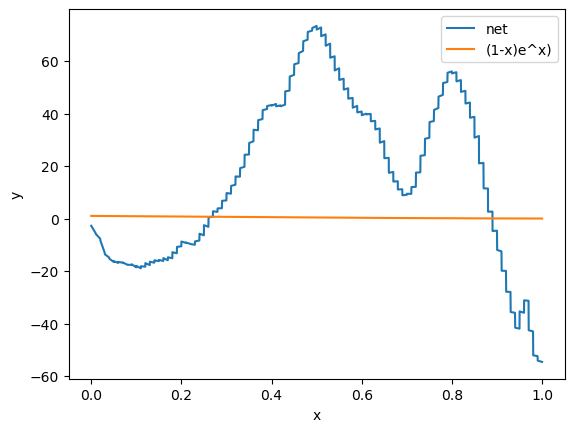

In [26]:
import matplotlib.pyplot as plt  
import numpy as np

bfl = net.models

def sol(n):
    x = torch.linspace(-1, 1, 100)[1:-1]
    xreal = torch.zeros_like(x)
    y = torch.zeros_like(x)
    for i in range(x.shape[0]):
        xreal[i] = ref2phi(x[i], n)
        y[i] = bfl[n](Tensor([xreal[i]]))
    return xreal, y

def tforigin(notf, n):
    x = torch.linspace(-1, 1, 100)[1:-1]
    xreal = torch.zeros_like(x)
    y = torch.zeros_like(x)
    for i in range(x.shape[0]):
        xreal[i] = ref2phi(x[i], n)
        y[i] = testfunc(Tensor([xreal[i]]), notf , n)
    return xreal, y

################################ plot the solution ####################################
XX = torch.tensor([])  
YY = torch.tensor([]) 
for i in range(N):
    xreal, y = sol(i)
    XX = torch.cat((XX, xreal), dim=0)
    YY = torch.cat((YY, y), dim=0)
XX = XX.detach().numpy()
YY = YY.detach().numpy()
plt.plot(XX, YY, label='net')
plt.xlabel('x') 
plt.ylabel('y') 

################################# plot test function ###################################
# for notf in range(3):
#     TF = torch.tensor([]) 
#     for i in range(N):
#         _, y = tforigin(notf, i)
#         TF = torch.cat((TF, y), dim=0)
#     TF = TF.detach().numpy()
#     plt.plot(XX, TF, label=f'tf{notf}')
    

################################# plot exact solution ###################################
x_values = np.linspace(0, 1, 1000)  # 生成 x 值  
y_values = (1 - x_values) * np.exp(-x_values**2)  # 计算对应的 y 值  
plt.plot(x_values, y_values, label='(1-x)e^x)')  


plt.xlabel('x')  
plt.ylabel('y')  
plt.legend() 
plt.show() 